In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from dataset_generator import generate_dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train, test = generate_dataset(2000)

In [4]:
train = np.array(train)
test = np.array(test)

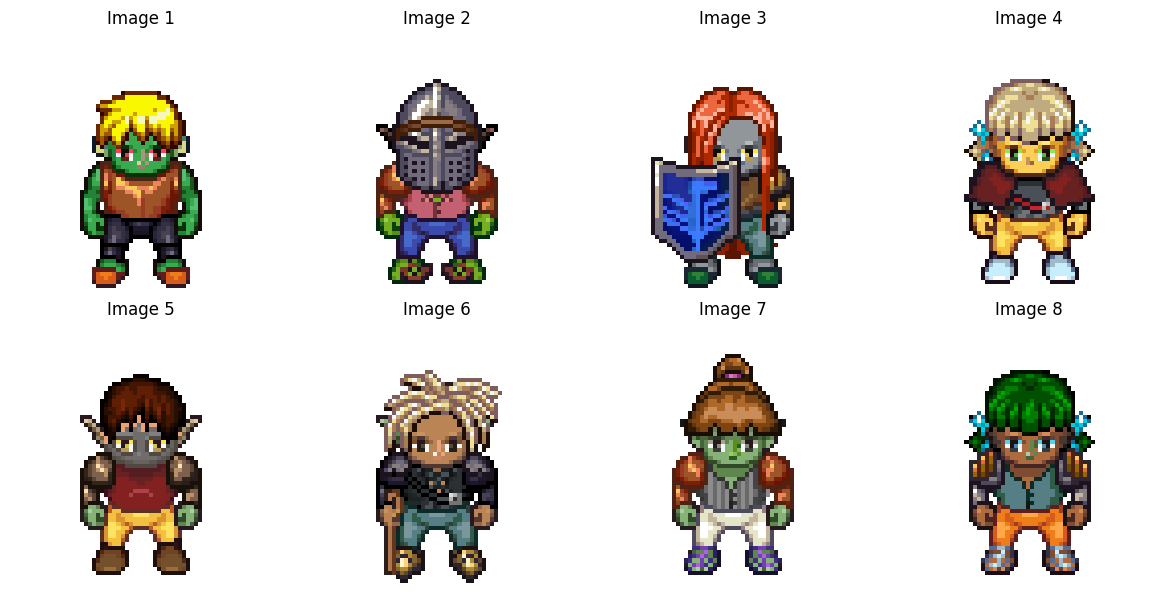

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Loop through the first 8 images and display them in the grid
for i, ax in enumerate(axes.ravel()):
    if i < len(train):
        img = train[i]  # Assuming 'images' is a NumPy array
        ax.imshow(img)
        ax.set_title(f"Image {i + 1}")
        ax.axis(False)
    else:
        # Remove empty subplots if there are fewer than 8 images
        fig.delaxes(ax)

# Adjust subplot spacing
plt.tight_layout()

# Show the grid of images
plt.show()

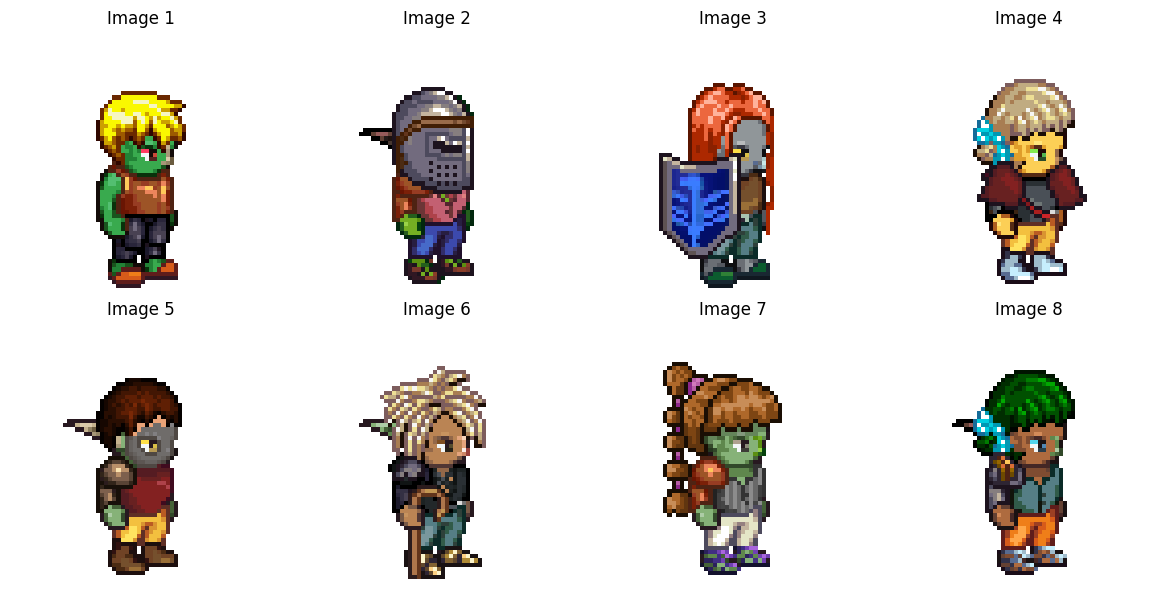

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Loop through the first 8 images and display them in the grid
for i, ax in enumerate(axes.ravel()):
    if i < len(train):
        img = test[i]  # Assuming 'images' is a NumPy array
        ax.imshow(img)
        ax.set_title(f"Image {i + 1}")
        ax.axis(False)
    else:
        # Remove empty subplots if there are fewer than 8 images
        fig.delaxes(ax)

# Adjust subplot spacing
plt.tight_layout()

# Show the grid of images
plt.show()

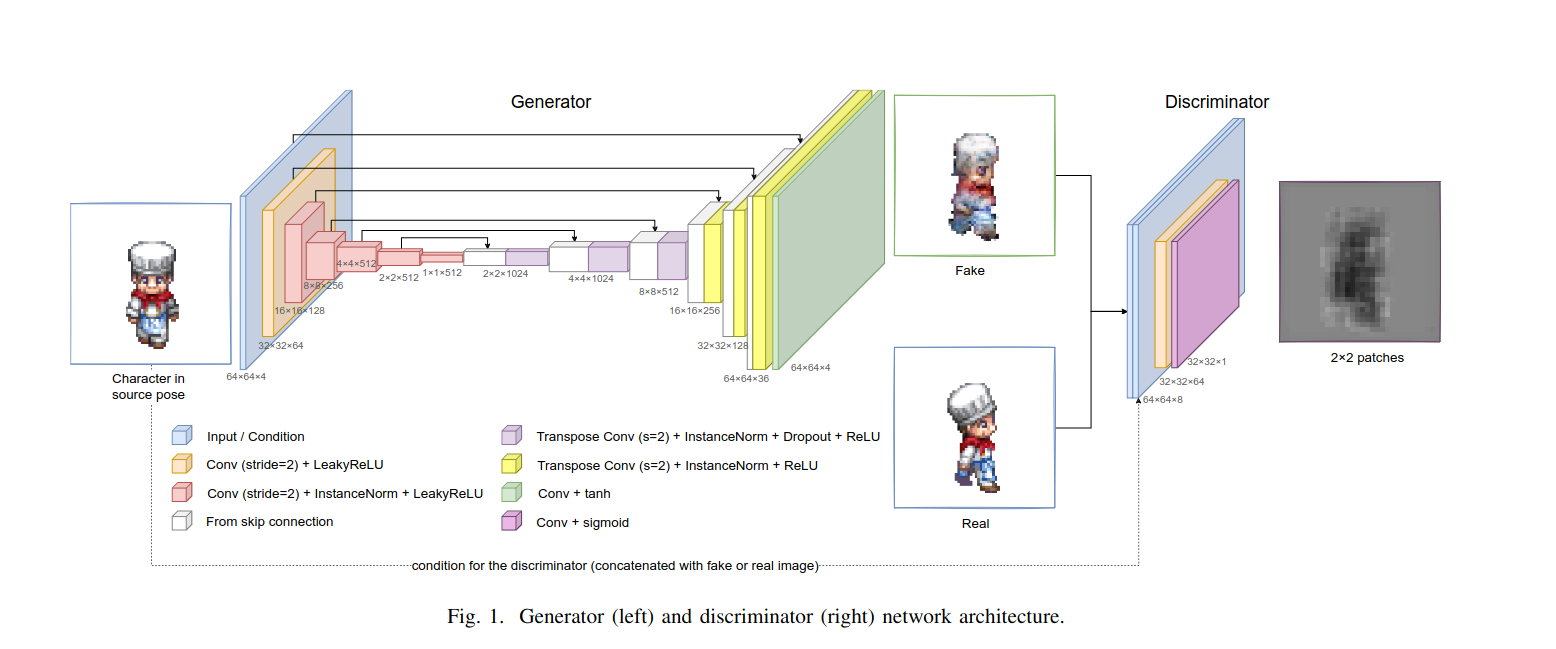

In [7]:
import torch
import torch.nn as nn


# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        out_channels = 64
        self.encoder = nn.ModuleList()

        in_channels = 4  # Input channels
        for _ in range(4):
            if in_channels == 4:
                self.encoder.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
                        nn.LeakyReLU(0.2),
                    )
                )
            else:
                self.encoder.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
                        nn.InstanceNorm2d(out_channels),
                        nn.LeakyReLU(0.2),
                    )
                )
            in_channels = out_channels
            out_channels *= 2

        self.encoder.append(
            nn.Sequential(
                nn.Conv2d(512, 512, 4, stride=2, padding=1),
                nn.InstanceNorm2d(512),
                nn.LeakyReLU(0.2),
            )
        )
        self.encoder.append(
            nn.Sequential(
                nn.Conv2d(512, 512, 4, stride=2, padding=1),
                # nn.InstanceNorm2d(512),
                nn.LeakyReLU(0.2),
            )
        )

        # Decoder blocks
        self.decoder = nn.ModuleList()

        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
                nn.InstanceNorm2d(512),
                nn.Dropout2d(),
                nn.ReLU(),
            )
        )
        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
                nn.InstanceNorm2d(512),
                nn.Dropout2d(),
                nn.ReLU(),
            )
        )
        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1),
                nn.InstanceNorm2d(256),
                nn.Dropout2d(),
                nn.ReLU(),
            )
        )
        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1),
                nn.ReLU(),
            )
        )

        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1),
                nn.ReLU(),
            )
        )
        self.decoder.append(
            nn.Sequential(
                nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1),
                nn.ReLU(),
            )
        )

        # Final convolution block with tanh activation
        self.final_conv = nn.Conv2d(36, 4, 3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder pass
        skip_connections = []
        skip_connections.append(x)
        for encoder_block in self.encoder:
            x = encoder_block(x)
            skip_connections.append(x)

        skip_connections.pop()

        # Decoder pass with skip connections
        for decoder_block, skip_connection in zip(
            self.decoder, reversed(skip_connections)
        ):
            print
            x = decoder_block(x)
            x = torch.cat((x, skip_connection), 1)

            # Concatenate skip connection

        # Final convolution and tanh activation
        x = self.final_conv(x)
        x = self.tanh(x)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(8, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
train = train.transpose((0, 3, 1, 2))

test = test.transpose((0, 3, 1, 2))

In [10]:
train.shape, test.shape

((20, 4, 64, 64), (20, 4, 64, 64))

In [11]:
train = torch.tensor(train).to(torch.float32)
test = torch.tensor(test).to(torch.float32)

In [12]:
train = train / 127.5 - 1.0
test = test / 127.5 - 1.0

In [13]:
train_dataset = TensorDataset(train, test)


batch_size = 1

# Create data loaders for training and test data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
generator = Generator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

In [15]:
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

In [16]:
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
steps = 40_000
lambda_L1 = 100

In [20]:
for step in range(steps):
    for batch_idx, (real_images, target_images) in enumerate(train_loader):
        real_images = real_images.to(device)
        target_images = target_images.to(device)
        valid = torch.ones((real_images.size(0), 1, 32, 32)).to(device)
        fake = torch.zeros((real_images.size(0), 1, 32, 32)).to(device)

        # -----------------
        # Train the Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate fake images
        generated_images = generator(real_images)

        dis_input = torch.cat((generated_images, real_images), dim=1)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(dis_input), valid)

        # L1 loss
        l1_term = lambda_L1 * l1_loss(generated_images, target_images)

        # Generator loss
        g_loss += l1_term
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train the Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        dis_input = torch.cat((target_images, real_images), dim=1)
        # Real images
        real_pred = discriminator(dis_input)
        d_real_loss = adversarial_loss(real_pred, valid)

        dis_input = torch.cat((generated_images.detach(), real_images), dim=1)
        # Fake images
        fake_pred = discriminator(dis_input)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print training information
    if step % 100 == 0:
        print(
            f"[Epoch {epoch}/{num_epochs}] [Batch {batch_idx}/{len(train_loader)}] "
            f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )
    if (step + 1) % 1000 == 0:
        torch.save(
            {
                "step": step + 1,
                "generator": generator.state_dict(),
                "generator_optim": optimizer_G.state_dict(),
                "discriminator": discriminator.state_dict(),
                "discrim_optim": optimizer_D.state_dict(),
            },
            f"checkpoints/{step+1}.pt",
        )

In [21]:
testttt, actualll = generate_dataset(1)

In [22]:
testttt = np.array(testttt)
actualll = np.array(actualll)

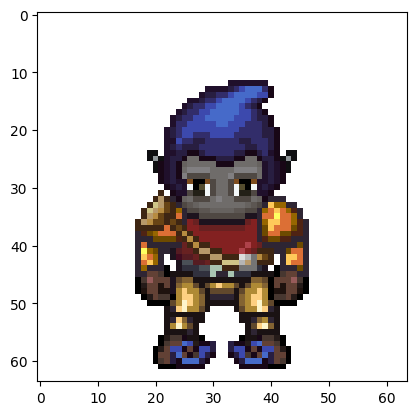

In [23]:
plt.imshow(testttt[0])

In [24]:
with torch.inference_mode():
    magiccc = generator(
        torch.tensor(testttt).permute((0, 3, 1, 2)).to(torch.float32).to(device)
    )

plott = magiccc.cpu().detach().numpy()[0].transpose((1, 2, 0))

In [25]:
plot_norm = (plott - np.min(plott)) / (np.max(plott) - np.min(plott))

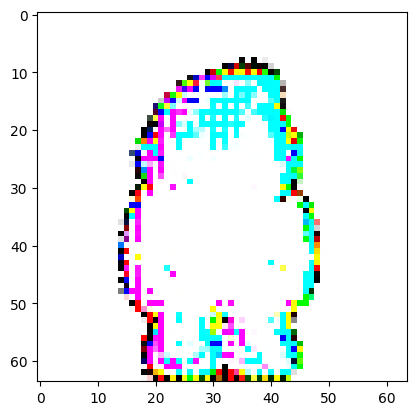

In [26]:
plt.imshow(plot_norm)

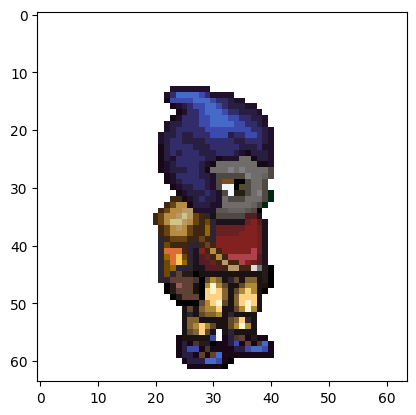

In [27]:
plt.imshow(actualll[0])